In [ ]:
# Taxonomy definitions: label, inclusion, and exclusion rules
TAXONOMY = [
    {
        "label": "Sale of Goods",
        "include": "Transfer of title or ownership in tangible, movable goods for a price; UCC-style language; delivery terms.",
        "exclude": "Any service-only arrangement; leases or rentals of personal property; intellectual-property licenses; financing terms; real estate transfers.",
    },
    {
        "label": "Real Estate Contracts",
        "include": "Conveyance, lease, mortgage or transfer of interests in land or buildings; phrases like 'grant, bargain and sell', 'mortgage', 'leasehold premises'.",
        "exclude": "Sale or lease of personal property; service, construction, or management agreements not tied to land; IP licenses.",
    },
    {
        "label": "Service Contracts",
        "include": "Provision of non-tangible services for compensation, such as consulting, repairs, maintenance, or software-as-a-service.",
        "exclude": "Sale or rental of goods; construction of real property; employment relationships; franchise or agency appointments; IP licensing.",
    },
    {
        "label": "Construction Contracts",
        "include": "Design, build, renovate or modify real property or structures; includes architectural, engineering, and construction work orders.",
        "exclude": "Pure supply of materials without installation; service contracts unrelated to physical construction; employment-only agreements.",
    },
    {
        "label": "Employment Contracts",
        "include": "Engagement of an individual as an employee, covering salary, benefits, duties, 'at-will' clauses, non-compete tied to employment.",
        "exclude": "Independent contractor or service-provider agreements; loan or financing contracts; agency appointments.",
    },
    {
        "label": "Insurance Contracts",
        "include": "Promise to indemnify or pay upon occurrence of an insured event; includes 'policy', 'premium', 'coverage'.",
        "exclude": "Indemnity clauses embedded in broader contracts; guarantee or surety contracts; service-only agreements.",
    },
    {
        "label": "Franchise Agreements",
        "include": "Grant of rights to operate a franchised business under franchisor's system; mentions 'franchise fee', 'territory', 'royalties'.",
        "exclude": "Simple IP licenses; distributor or dealership agreements; agency or service-only contracts.",
    },
    {
        "label": "Licensing Agreements",
        "include": "Permission to use intellectual property or intangible assets (patents, trademarks, software) for a fee or royalty.",
        "exclude": "Sale of goods; franchise arrangements; service contracts; leases.",
    },
    {
        "label": "Loan Agreements",
        "include": "Lender-borrower relationship detailing principal, interest rate, and repayment schedule; mentions 'loan', 'principal', 'interest'.",
        "exclude": "Sale/lease of goods; investment or subscription agreements; guarantee contracts.",
    },
    {
        "label": "Partnership Agreements",
        "include": "Creation of a partnership or joint venture; references 'partners', 'capital contributions', 'profit share'.",
        "exclude": "Service-only agreements; corporate bylaws; LLC operating agreements treated outside partnership scope.",
    },
    {
        "label": "Lease Agreements",
        "include": "Grant of possession/use of property (real or personal) for a defined term in exchange for rent; mentions 'demised premises', 'lease term', 'rent'.",
        "exclude": "Sales contracts; maintenance agreements; subcontracts to perform work on leased property.",
    },
    {
        "label": "Settlement Agreements",
        "include": "Resolution of disputes or claims; contains 'release', 'covenant not to sue', or dismissal terms.",
        "exclude": "Insurance policies; NDAs alone; indemnity clauses inside larger contracts.",
    },
    {
        "label": "Indemnity Contracts",
        "include": "Promise to hold another harmless against losses or claims; phrases like 'indemnify and defend', 'hold harmless'.",
        "exclude": "Embedded indemnity clauses in other contracts; insurance or guarantee policies.",
    },
    {
        "label": "Confidentiality (NDA) Agreements",
        "include": "Contracts that are not primarily for Confidentiality: Obligations not to disclose certain non-public information; mentions 'confidential information', 'purpose', 'return of materials'.",
        "exclude": "Contracts that are not primarily for Confidentiality even if confidentiality clauses present. Be aware that many contracts that are not primarily for Confidentiality have clauses such as 'Confidential treatment has been requested'",
    },
    {
        "label": "Guarantee Contracts",
        "include": "Third party's promise to fulfill another's obligation upon default; contains 'guarantor', 'guarantee', 'in case of default'.",
        "exclude": "Primary loan agreements; indemnity contracts; insurance policies.",
    },
    {
        "label": "Agency Agreements",
        "include": "Appointment of an agent to act on behalf of a principal; uses 'agent', 'authority', 'fiduciary', 'commission'.",
        "exclude": "Employment contracts; distributor/dealership agreements; partnership agreements.",
    },
]

In [ ]:
import json
import re
import textwrap

import openai
import pandas as pd
from google.colab import userdata
from IPython.display import display

openai.api_key = userdata.get("OPENAI_2")

In [ ]:
def load_contracts(json_paths):
    """
    Load contract data from JSON files into a pandas DataFrame.

    Args:
        json_paths (list): List of file paths to JSON files containing contract data.

    Returns:
        pd.DataFrame: DataFrame containing all contract data from the specified JSON files.
    """
    rows = []
    for path in json_paths:
        with open(path, encoding="utf-8") as f:
            data = json.load(f)
            rows.extend(data)
    return pd.DataFrame(rows)


# Helper to build the taxonomy prompt string
def build_taxonomy_prompt(taxonomy):
    """
    Builds a formatted string from taxonomy data for use in prompts.

    Args:
        taxonomy (list): List of dictionaries with 'label', 'include', and 'exclude' keys.

    Returns:
        str: Formatted string containing taxonomy information for prompting.
    """
    lines = []
    for entry in taxonomy:
        lines.append(f"{entry['label']}:\n  Include: {entry['include']}\n  Exclude: {entry['exclude']}\n")
    return "\n".join(lines)


TAXONOMY_PROMPT = build_taxonomy_prompt(TAXONOMY)

In [ ]:
# Helper for parsing response
def _extract_json(content: str) -> str:
    # More flexible regex to capture JSON array, even if it is not enclosed in code fences.
    pattern = re.compile(r"```(?:json)?\s*(\[\s*[\s\S]*?\])\s*```", re.IGNORECASE)
    m = pattern.search(content)
    return m.group(1) if m else content


# Seed labeling function
def label_seed_documents(
    df: pd.DataFrame,
    text_col: str = "text",
    id_col: str = "id",
    seed_size: int = 200,
    batch_size: int = 20,
    max_char: int = 2000,
    specific_ids: list[str] | None = None,
) -> pd.DataFrame:
    """Samples `seed_size` docs from df, batches them, and uses chatgpt to label each
    document with one of the TAXONOMY labels. Returns a DataFrame with:
    [id, snippet, predicted_label, confidence, rationale].
    """
    # Sample
    seed_df = df[df[id_col].isin(specific_ids)].reset_index(drop=True) if specific_ids is not None else df.sample(n=seed_size).reset_index(drop=True)

    results = []

    # Process in batches
    for i in range(0, seed_size, batch_size):
        batch = seed_df.iloc[i : i + batch_size]
        items = []
        snippet_map = {}
        for _, row in batch.iterrows():
            sid = str(row[id_col])  # normalize to string
            snippet = textwrap.shorten(row[text_col], width=max_char, placeholder="…")
            items.append({"id": sid, "text": snippet})
            snippet_map[sid] = snippet

        # Build prompt
        system_msg = {
            "role": "system",
            "content": ("You are a legal contract classification assistant. Assign each contract to exactly one of the 16 provided types."),
        }
        user_msg = {
            "role": "user",
            "content": (
                f"Here are the definitions for each contract type:\n\n"
                f"{TAXONOMY_PROMPT}\n\n"
                f"Classify the following contracts.  Respond with a JSON array of objects:\n"
                f'[{{"id": str, "predicted_label": str, "confidence": float (0-1), "rationale": str}}]\n\n'
                f"Contracts:\n" + "\n".join(f"ID: {it['id']}\nText: {it['text']}\n" for it in items)
            ),
        }

        # Call OpenAI
        response = openai.chat.completions.create(model="gpt-4o-mini", messages=[system_msg, user_msg], temperature=0.0, max_tokens=2048)

        # Parse JSON
        raw = response.choices[0].message.content.strip()
        payload = _extract_json(raw)

        try:
            parsed = json.loads(payload)
        except json.JSONDecodeError:
            raise ValueError(f"Could not parse JSON. Raw:\n{raw}\n\nExtracted:\n{payload}") from json.JSONDecodeError

        # Collect
        for obj in parsed:
            sid = str(obj.get("id", ""))
            snippet = snippet_map.get(sid, "")
            if snippet == "":
                print(f"Warning: ID {sid} not found in this batch, leaving snippet blank.")
            results.append(
                {
                    "id": sid,
                    "snippet": snippet,
                    "predicted_label": obj.get("predicted_label", ""),
                    "confidence": obj.get("confidence", None),
                    "rationale": obj.get("rationale", ""),
                }
            )

    return pd.DataFrame(results)

In [15]:
df2 = load_contracts(
    [
        "heads_1.json",
    ]
)

In [16]:
extended_label = label_seed_documents(df2, seed_size=5000, batch_size=10)

In [20]:
extended_label.head()

,id,snippet,predicted_label,confidence,rationale
0,cuad2015000036044,Exhibit 10.2 LOAN AGREEMENT Dated as of July 3...,Loan Agreements,0.95,The text describes a loan agreement detailing ...
1,cuad2015000001538,EMPLOYMENT AGREEMENT As Amended and Restated T...,Employment Contracts,0.98,The text outlines an employment agreement betw...
2,cuad2002000001129,Exhibit 10.67 Schedule of Project Loans under ...,Loan Agreements,0.90,The text refers to a schedule of project loans...
3,cuad2001000002947,Exhibit 10.36 CHANGE OF CONTROL AGREEMENT AGRE...,Employment Contracts,0.92,The text describes a change of control agreeme...
4,cuad2019000003743,"CPI AEROSTRUCTURES, INC. 8-K [cvu-8k_111219.ht...",Employment Contracts,0.93,The text outlines a severance and change in co...


In [21]:
extended_label = extended_label.dropna(subset=["predicted_label"])

labels = [
    "Agency Agreements",
    "Confidentiality (NDA) Agreements",
    "Construction Contracts",
    "Employment Contracts",
    "Franchise Agreements",
    "Guarantee Contracts",
    "Indemnity Contracts",
    "Insurance Contracts",
    "Lease Agreements",
    "Licensing Agreements",
    "Loan Agreements",
    "Partnership Agreements",
    "Real Estate Contracts",
    "Sale of Goods",
    "Service Contracts",
    "Settlement Agreements",
]

extended_label = extended_label[extended_label["predicted_label"].isin(labels)]

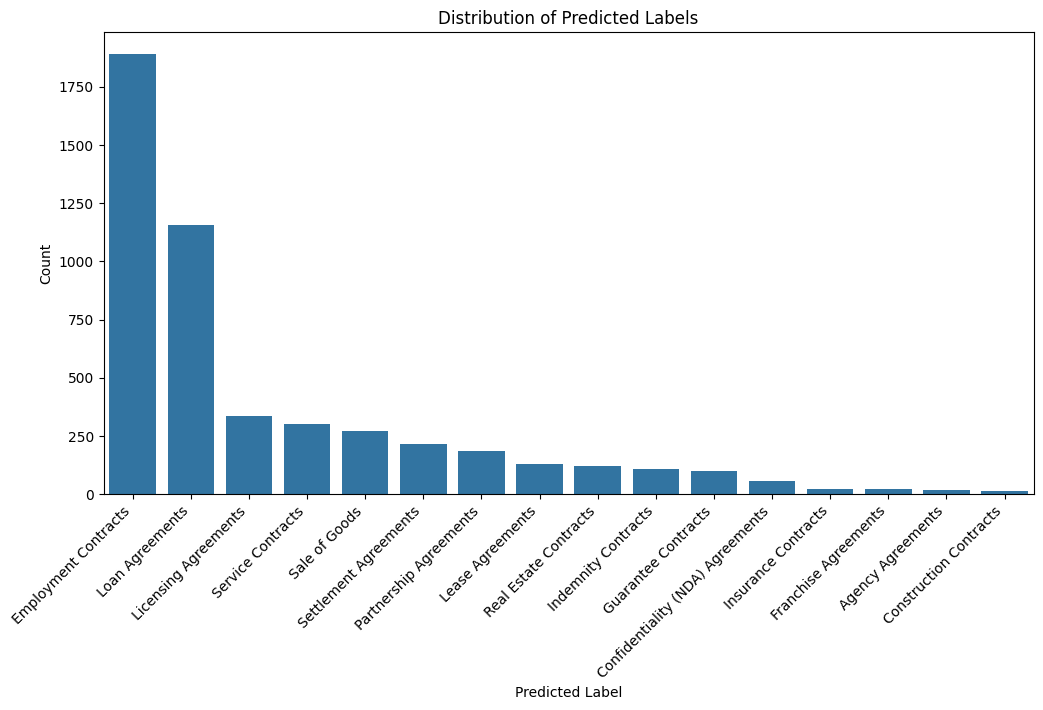

,Predicted Label,Count
0,Employment Contracts,1890
1,Loan Agreements,1154
2,Licensing Agreements,334
3,Service Contracts,303
4,Sale of Goods,269
5,Settlement Agreements,217
6,Partnership Agreements,186
7,Lease Agreements,129
8,Real Estate Contracts,119
9,Indemnity Contracts,106


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(
    x="predicted_label",
    data=extended_label,
    order=extended_label["predicted_label"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Predicted Labels")
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.show()

label_counts = extended_label["predicted_label"].value_counts().reset_index()
label_counts.columns = ["Predicted Label", "Count"]
display(label_counts)